### __Load Data__

In [1]:
import model_utils
import pandas as pd

merged_hornsea = pd.read_parquet("preprocessed_hornsea_with_energy.parquet")
merged_pes = pd.read_parquet("preprocessed_pes_with_energy.parquet")

### __Feature Engineering__

In [2]:
import importlib
import Preprocessing
importlib.reload(Preprocessing)



feature_engineerer_wind = Preprocessing.FeatureEngineerer(label = 'Wind_MWh_credit', columns_to_ohe = ['unavailabilityType', 'affectedUnit'])
feature_engineerer_wind.perform_feature_engineering(merged_hornsea, deployment = False)

feature_engineerer_solar = Preprocessing.FeatureEngineerer(label = "Solar_MWh_credit")
feature_engineerer_solar.perform_feature_engineering(merged_pes, deployment = False)

merged_pes_simple = merged_pes[['solar_down_rad', 'Solar_MWh_credit', 'Wind_MWh_credit']]
feature_engineerer_solar_baseline = Preprocessing.FeatureEngineerer(label = 'Solar_MWh_credit')
feature_engineerer_solar_baseline.perform_feature_engineering(merged_pes_simple, deployment = False)

merged_hornsea_simple = merged_hornsea[['wind_speed_100', 'Solar_MWh_credit', 'Wind_MWh_credit']]
feature_engineerer_wind_baseline = Preprocessing.FeatureEngineerer(label = 'Wind_MWh_credit')
feature_engineerer_wind_baseline.perform_feature_engineering(merged_hornsea_simple, deployment = False)

### __Baseline wind energy forecast__

In [3]:
import model_utils
import numpy as np
import importlib
importlib.reload(model_utils)

quantiles = np.arange(0.1, 1.0, 0.1)
quantiles = np.round(quantiles, 1)

# Specify model save directory
model_save_dir_qr = "qr_model_wind"

qr_model_wind = model_utils.QuantileRegressorModel(feature_engineerer_wind_baseline, quantiles, model_save_dir=model_save_dir_qr, load_pretrained=True)
qr_model_wind.train_and_predict()  # This will skip training for already loaded models
print(f"Quantile Regressor Pinball Score: {qr_model_wind.pinball_score()}")

Loaded pretrained Quantile Regressor model for quantile 0.1 from qr_model_wind\qr_model_quantile_0.1.pkl
Loaded pretrained Quantile Regressor model for quantile 0.2 from qr_model_wind\qr_model_quantile_0.2.pkl
Loaded pretrained Quantile Regressor model for quantile 0.3 from qr_model_wind\qr_model_quantile_0.3.pkl
Loaded pretrained Quantile Regressor model for quantile 0.4 from qr_model_wind\qr_model_quantile_0.4.pkl
Loaded pretrained Quantile Regressor model for quantile 0.5 from qr_model_wind\qr_model_quantile_0.5.pkl
Loaded pretrained Quantile Regressor model for quantile 0.6 from qr_model_wind\qr_model_quantile_0.6.pkl
Loaded pretrained Quantile Regressor model for quantile 0.7 from qr_model_wind\qr_model_quantile_0.7.pkl
Loaded pretrained Quantile Regressor model for quantile 0.8 from qr_model_wind\qr_model_quantile_0.8.pkl
Loaded pretrained Quantile Regressor model for quantile 0.9 from qr_model_wind\qr_model_quantile_0.9.pkl
Using the loaded pretrained Quantile Regressor model fo

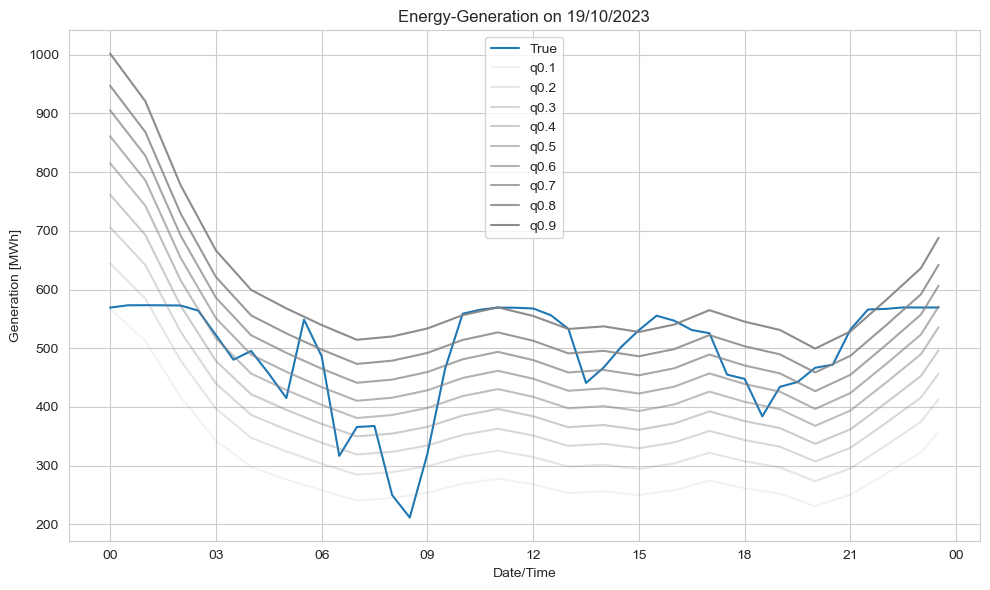

In [4]:
qr_model_wind.plot_quantils(feature_engineerer_wind_baseline.y_test.index, qr_model_wind.q_predictions, quantiles=quantiles, year=2023, month=10, day=19)

### __Baseline solar energy forecast__

In [5]:
quantiles = np.arange(0.1, 1.0, 0.1)
quantiles = np.round(quantiles, 1)

# Specify model save directory
model_save_dir_qr = "qr_model_solar"

qr_model_solar = model_utils.QuantileRegressorModel(feature_engineerer_solar_baseline, quantiles, model_save_dir=model_save_dir_qr, load_pretrained=True)
qr_model_solar.train_and_predict()  # This will skip training for already loaded models
print(f"Quantile Regressor Pinball Score: {qr_model_solar.pinball_score()}")

Loaded pretrained Quantile Regressor model for quantile 0.1 from qr_model_solar\qr_model_quantile_0.1.pkl
Loaded pretrained Quantile Regressor model for quantile 0.2 from qr_model_solar\qr_model_quantile_0.2.pkl
Loaded pretrained Quantile Regressor model for quantile 0.3 from qr_model_solar\qr_model_quantile_0.3.pkl
Loaded pretrained Quantile Regressor model for quantile 0.4 from qr_model_solar\qr_model_quantile_0.4.pkl
Loaded pretrained Quantile Regressor model for quantile 0.5 from qr_model_solar\qr_model_quantile_0.5.pkl
Loaded pretrained Quantile Regressor model for quantile 0.6 from qr_model_solar\qr_model_quantile_0.6.pkl
Loaded pretrained Quantile Regressor model for quantile 0.7 from qr_model_solar\qr_model_quantile_0.7.pkl
Loaded pretrained Quantile Regressor model for quantile 0.8 from qr_model_solar\qr_model_quantile_0.8.pkl
Loaded pretrained Quantile Regressor model for quantile 0.9 from qr_model_solar\qr_model_quantile_0.9.pkl
Using the loaded pretrained Quantile Regressor

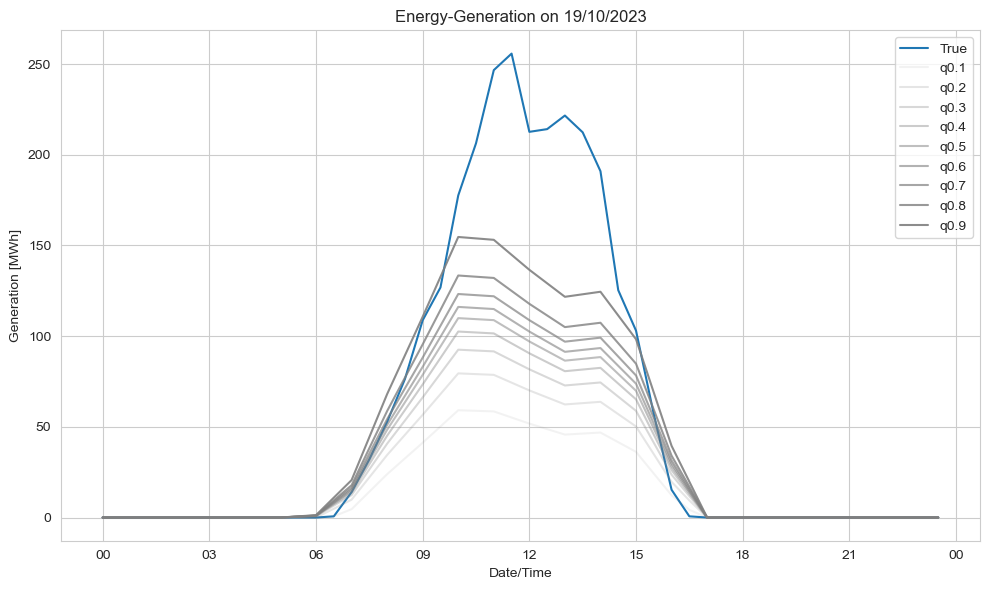

In [6]:
qr_model_solar.plot_quantils(daterange=feature_engineerer_solar_baseline.y_test.index, y=qr_model_solar.q_predictions, quantiles=quantiles, year=2023, month=10, day=19)

### __LightGBM wind energy forecast__

In [7]:
importlib.reload(model_utils)

quantiles = np.arange(0.1, 1.0, 0.1)
quantiles = np.round(quantiles, 1)

# Specify model save directory
model_save_dir_qr = "lgbm_model_wind"

lgbm_model_wind = model_utils.LGBMRegressorModel(feature_engineerer_wind, quantiles, model_save_dir=model_save_dir_qr, load_pretrained=True)
lgbm_model_wind.train_and_predict()  # This will skip training for already loaded models
print(f"Quantile Regressor Pinball Score: {lgbm_model_wind.pinball_score()}")

Loaded pretrained Quantile Regressor model for quantile 0.1 from lgbm_model_wind\lgbm_model_quantile_0.1.pkl
Loaded pretrained Quantile Regressor model for quantile 0.2 from lgbm_model_wind\lgbm_model_quantile_0.2.pkl
Loaded pretrained Quantile Regressor model for quantile 0.3 from lgbm_model_wind\lgbm_model_quantile_0.3.pkl
Loaded pretrained Quantile Regressor model for quantile 0.4 from lgbm_model_wind\lgbm_model_quantile_0.4.pkl
Loaded pretrained Quantile Regressor model for quantile 0.5 from lgbm_model_wind\lgbm_model_quantile_0.5.pkl
Loaded pretrained Quantile Regressor model for quantile 0.6 from lgbm_model_wind\lgbm_model_quantile_0.6.pkl
Loaded pretrained Quantile Regressor model for quantile 0.7 from lgbm_model_wind\lgbm_model_quantile_0.7.pkl
Loaded pretrained Quantile Regressor model for quantile 0.8 from lgbm_model_wind\lgbm_model_quantile_0.8.pkl
Loaded pretrained Quantile Regressor model for quantile 0.9 from lgbm_model_wind\lgbm_model_quantile_0.9.pkl
Using the loaded pr

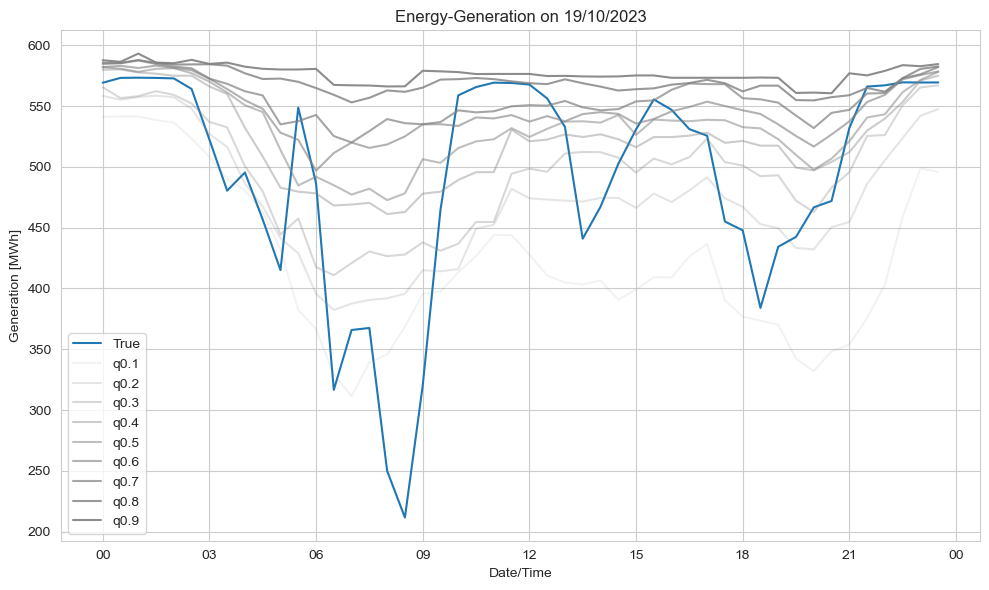

In [8]:
lgbm_model_wind.plot_quantils(feature_engineerer_wind.y_test.index, lgbm_model_wind.q_predictions, quantiles, month=10, day=19)

### __LightGBM solar energy forecast__

In [9]:
quantiles = np.arange(0.1, 1.0, 0.1)
quantiles = np.round(quantiles, 1)

# Specify model save directory
model_save_dir_qr = "lgbm_model_solar"

lgbm_model_solar = model_utils.LGBMRegressorModel(feature_engineerer_solar, quantiles, model_save_dir=model_save_dir_qr, load_pretrained=True)
lgbm_model_solar.train_and_predict()  # This will skip training for already loaded models
print(f"Quantile Regressor Pinball Score: {lgbm_model_solar.pinball_score()}")

Loaded pretrained Quantile Regressor model for quantile 0.1 from lgbm_model_solar\lgbm_model_quantile_0.1.pkl
Loaded pretrained Quantile Regressor model for quantile 0.2 from lgbm_model_solar\lgbm_model_quantile_0.2.pkl
Loaded pretrained Quantile Regressor model for quantile 0.3 from lgbm_model_solar\lgbm_model_quantile_0.3.pkl
Loaded pretrained Quantile Regressor model for quantile 0.4 from lgbm_model_solar\lgbm_model_quantile_0.4.pkl
Loaded pretrained Quantile Regressor model for quantile 0.5 from lgbm_model_solar\lgbm_model_quantile_0.5.pkl
Loaded pretrained Quantile Regressor model for quantile 0.6 from lgbm_model_solar\lgbm_model_quantile_0.6.pkl
Loaded pretrained Quantile Regressor model for quantile 0.7 from lgbm_model_solar\lgbm_model_quantile_0.7.pkl
Loaded pretrained Quantile Regressor model for quantile 0.8 from lgbm_model_solar\lgbm_model_quantile_0.8.pkl
Loaded pretrained Quantile Regressor model for quantile 0.9 from lgbm_model_solar\lgbm_model_quantile_0.9.pkl
Using the 

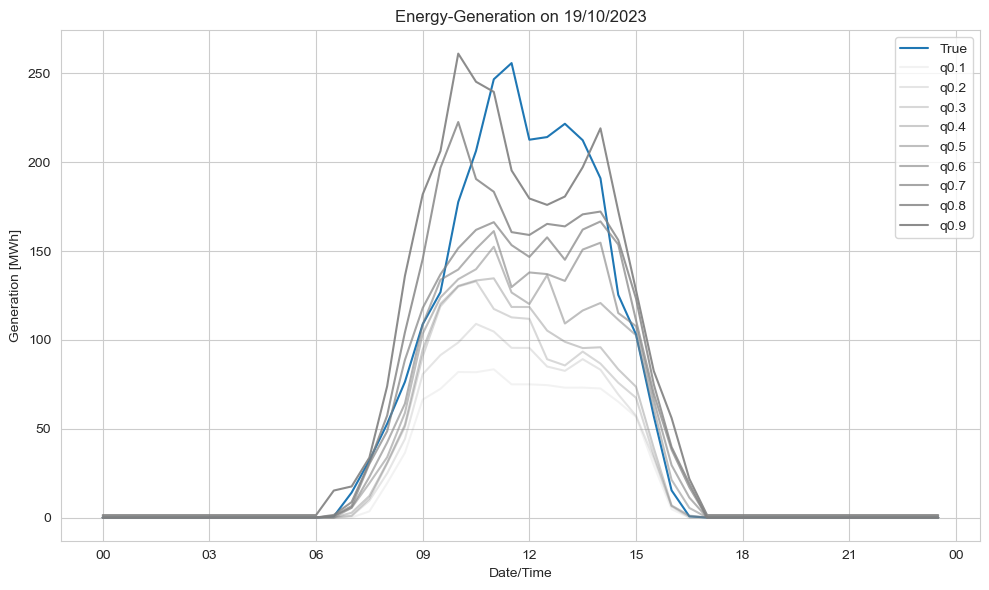

In [10]:
lgbm_model_solar.plot_quantils(feature_engineerer_solar.y_test.index, lgbm_model_solar.q_predictions, quantiles, year=2023, month=10, day=19)

### __Vergleich der Pinball Scores der Modelle__

In [11]:
performance_scores = {'Solarenergie' : [qr_model_solar.pinball_score(), lgbm_model_solar.pinball_score()],
                      'Windenergie' : [qr_model_wind.pinball_score(), lgbm_model_wind.pinball_score()]
                      }
performance_df = pd.DataFrame(performance_scores, index=["baseline", "LightGBM"])
performance_df

,Solarenergie,Windenergie
baseline,11.914653,31.795997
LightGBM,8.938359,21.476032


### __Modell Training all in one Modell__

In [12]:
import model_utils
import pandas as pd
import importlib
importlib.reload(model_utils)

merged_hornsea = pd.read_parquet("preprocessed_hornsea_with_energy.parquet")
merged_pes = pd.read_parquet("preprocessed_pes_with_energy.parquet")

columns_to_add = list()

for col in merged_hornsea.columns:
    if col not in merged_pes.columns:
        columns_to_add.append(col)

merged_all = merged_pes.merge(merged_hornsea[columns_to_add], left_index = True, right_index = True)
merged_all["energy"] = merged_all["Solar_MWh_credit"] + merged_all["Wind_MWh_credit"]
merged_all.drop(["Solar_MWh_credit", "Wind_MWh_credit"], axis = 1, inplace = True)

from Preprocessing import *
feature_engineerer_all = FeatureEngineerer(labels_to_remove=  ["energy"], columns_to_ohe = ['unavailabilityType', 'affectedUnit'], label = ["energy"])
feature_engineerer_all.perform_feature_engineering(merged_all, deployment = False, labels_to_remove=  ["energy"])

import numpy as np
quantiles = np.arange(0.1, 1.0, 0.1).round(2)

# Specify model save directory
model_save_dir_qr = "lgbm_model_all"

lgbm_model = model_utils.LGBMRegressorModel(feature_engineerer_all, quantiles, model_save_dir=model_save_dir_qr, load_pretrained=True)
lgbm_model.train_and_predict()  # This will skip training for already loaded models
print(f"Quantile Regressor Pinball Score: {lgbm_model.pinball_score()}")

Loaded pretrained Quantile Regressor model for quantile 0.1 from lgbm_model_all\lgbm_model_quantile_0.1.pkl
Loaded pretrained Quantile Regressor model for quantile 0.2 from lgbm_model_all\lgbm_model_quantile_0.2.pkl
Loaded pretrained Quantile Regressor model for quantile 0.3 from lgbm_model_all\lgbm_model_quantile_0.3.pkl
Loaded pretrained Quantile Regressor model for quantile 0.4 from lgbm_model_all\lgbm_model_quantile_0.4.pkl
Loaded pretrained Quantile Regressor model for quantile 0.5 from lgbm_model_all\lgbm_model_quantile_0.5.pkl
Loaded pretrained Quantile Regressor model for quantile 0.6 from lgbm_model_all\lgbm_model_quantile_0.6.pkl
Loaded pretrained Quantile Regressor model for quantile 0.7 from lgbm_model_all\lgbm_model_quantile_0.7.pkl
Loaded pretrained Quantile Regressor model for quantile 0.8 from lgbm_model_all\lgbm_model_quantile_0.8.pkl
Loaded pretrained Quantile Regressor model for quantile 0.9 from lgbm_model_all\lgbm_model_quantile_0.9.pkl
Using the loaded pretrained 

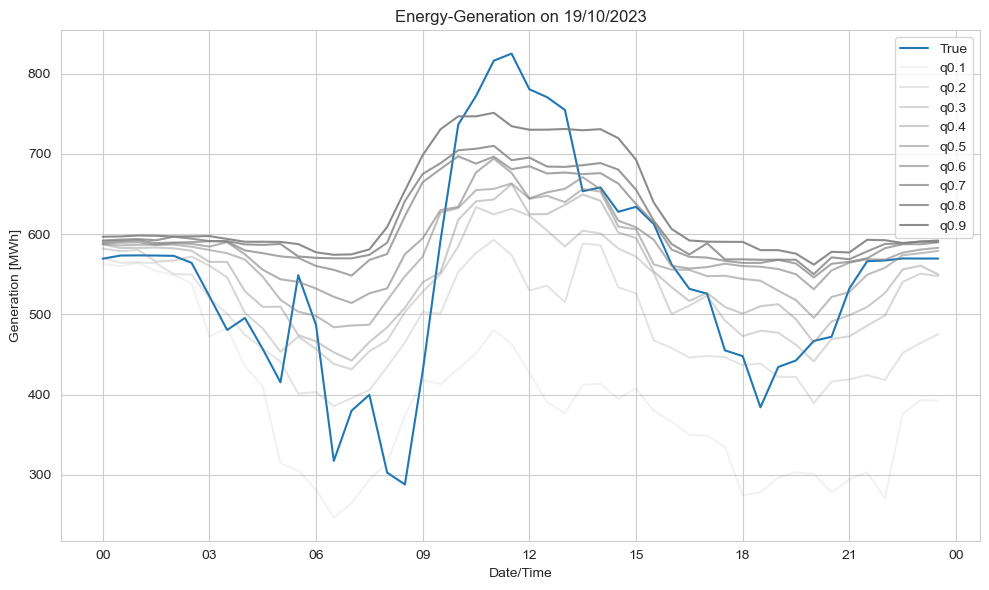

In [13]:
lgbm_model.plot_quantils(feature_engineerer_all.y_test.index, lgbm_model.q_predictions, quantiles, year=2023, month=10, day=19)

### __Combine Solar and Wind Modell for comparison__

In [14]:
solar_energy = lgbm_model_solar.q_predictions
wind_energy = lgbm_model_wind.q_predictions

combined_energy = {key: solar_energy[key] + wind_energy[key] for key in solar_energy}

model_utils.pinball_score(combined_energy, quantiles)

26.09143426874892

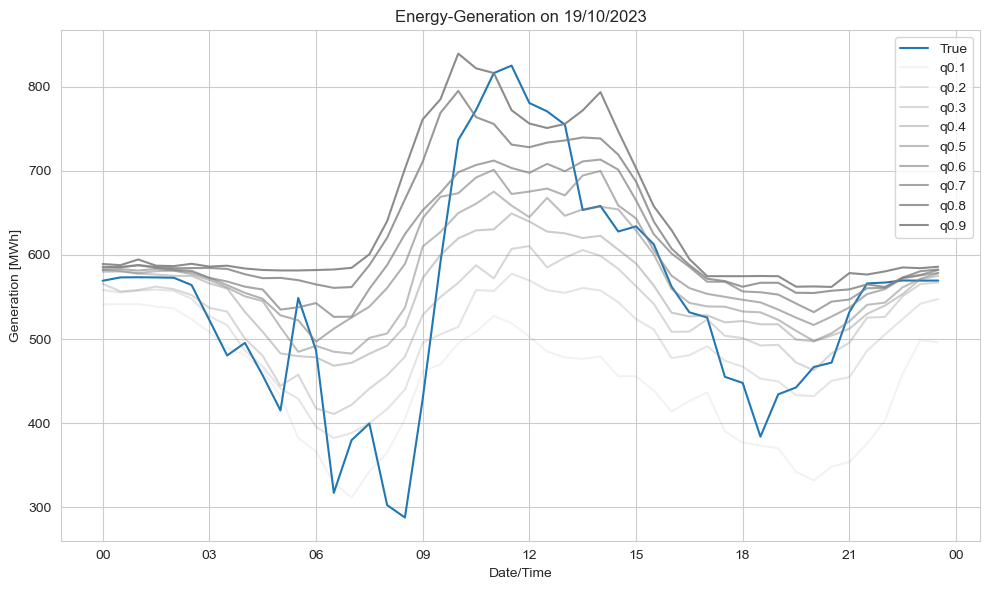

In [15]:
lgbm_model.plot_quantils(feature_engineerer_all.y_test.index, combined_energy, quantiles, year=2023, month=10, day=19)

In [16]:
performance_scores = {'Gesamt_Modell' : [lgbm_model.pinball_score()],
                      'Kombiniertes_Modell' : [model_utils.pinball_score(combined_energy, quantiles)]
                      }
performance_df = pd.DataFrame(performance_scores, index=["total_energy_without_HT"])
performance_df

,Gesamt_Modell,Kombiniertes_Modell
total_energy_without_HT,26.247761,26.091434


### __Use Hyperparametertuning for LightGBM__

__Wind__

In [17]:
importlib.reload(model_utils)
from scipy.stats import randint, uniform

quantiles = np.arange(0.1, 1.0, 0.1)
quantiles = np.round(quantiles, 1)

# Specify model save directory
model_save_dir_qr = "lgbm_model_wind_hyperparameter"

params_distributions = dict(
    num_leaves=randint(low=10, high=50),
    max_depth=randint(low=3, high=20),
    n_estimators=randint(low=100, high=800),
    learning_rate=uniform()
)

lgbm_model_wind_hyperparameter = model_utils.LGBMRegressorModel(feature_engineerer_wind, quantiles, model_save_dir=model_save_dir_qr, load_pretrained=True)
lgbm_model_wind_hyperparameter.train_and_predict_hyperparametertuning(params_distributions, search="RandomSearch")  # This will skip training for already loaded models
print(f"Quantile Regressor Pinball Score: {lgbm_model_wind_hyperparameter.pinball_score()}")

Loaded pretrained Quantile Regressor model for quantile 0.1 from lgbm_model_wind_hyperparameter\lgbm_model_quantile_0.1.pkl
Loaded pretrained Quantile Regressor model for quantile 0.2 from lgbm_model_wind_hyperparameter\lgbm_model_quantile_0.2.pkl
Loaded pretrained Quantile Regressor model for quantile 0.3 from lgbm_model_wind_hyperparameter\lgbm_model_quantile_0.3.pkl
Loaded pretrained Quantile Regressor model for quantile 0.4 from lgbm_model_wind_hyperparameter\lgbm_model_quantile_0.4.pkl
Loaded pretrained Quantile Regressor model for quantile 0.5 from lgbm_model_wind_hyperparameter\lgbm_model_quantile_0.5.pkl
Loaded pretrained Quantile Regressor model for quantile 0.6 from lgbm_model_wind_hyperparameter\lgbm_model_quantile_0.6.pkl
Loaded pretrained Quantile Regressor model for quantile 0.7 from lgbm_model_wind_hyperparameter\lgbm_model_quantile_0.7.pkl
Loaded pretrained Quantile Regressor model for quantile 0.8 from lgbm_model_wind_hyperparameter\lgbm_model_quantile_0.8.pkl
Loaded p

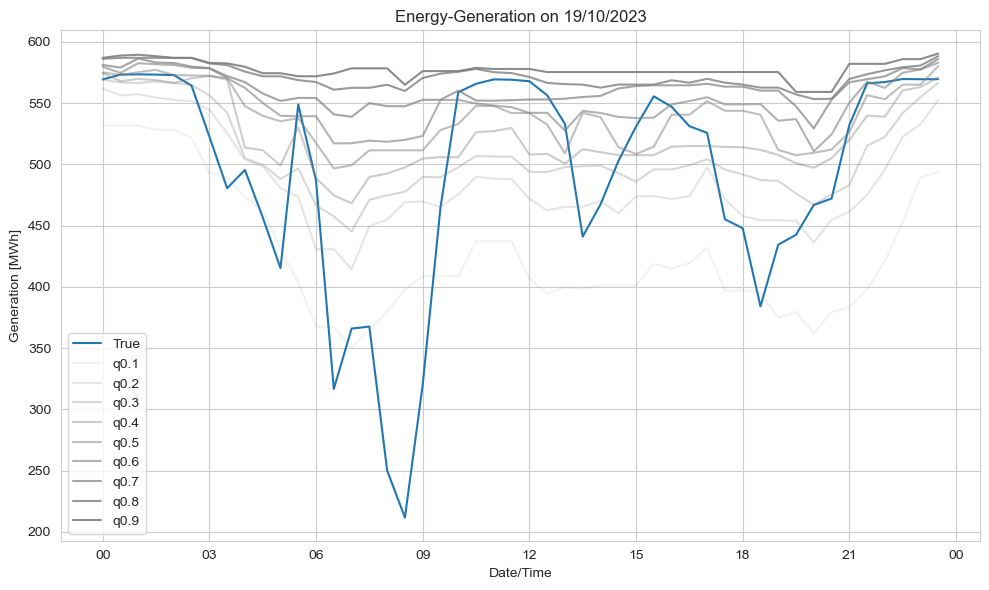

In [18]:
lgbm_model_wind_hyperparameter.plot_quantils(feature_engineerer_wind.y_test.index, lgbm_model_wind_hyperparameter.q_predictions, quantiles, year=2023, month=10, day=19)

__solar__

In [19]:
importlib.reload(model_utils)

quantiles = np.arange(0.1, 1.0, 0.1)
quantiles = np.round(quantiles, 1)

# Specify model save directory
model_save_dir_qr = "lgbm_model_solar_hyperparameter"

params_distributions = dict(
    num_leaves=randint(low=10, high=50),
    max_depth=randint(low=3, high=20),
    n_estimators=randint(low=100, high=800),
    learning_rate=uniform()
)

lgbm_model_solar_hyperparameter = model_utils.LGBMRegressorModel(feature_engineerer_solar, quantiles, model_save_dir=model_save_dir_qr, load_pretrained=True)
lgbm_model_solar_hyperparameter.train_and_predict_hyperparametertuning(params_distributions, search="RandomSearch")  # This will skip training for already loaded models
print(f"Quantile Regressor Pinball Score: {lgbm_model_solar_hyperparameter.pinball_score()}")

Loaded pretrained Quantile Regressor model for quantile 0.1 from lgbm_model_solar_hyperparameter\lgbm_model_quantile_0.1.pkl
Loaded pretrained Quantile Regressor model for quantile 0.2 from lgbm_model_solar_hyperparameter\lgbm_model_quantile_0.2.pkl
Loaded pretrained Quantile Regressor model for quantile 0.3 from lgbm_model_solar_hyperparameter\lgbm_model_quantile_0.3.pkl
Loaded pretrained Quantile Regressor model for quantile 0.4 from lgbm_model_solar_hyperparameter\lgbm_model_quantile_0.4.pkl
Loaded pretrained Quantile Regressor model for quantile 0.5 from lgbm_model_solar_hyperparameter\lgbm_model_quantile_0.5.pkl
Loaded pretrained Quantile Regressor model for quantile 0.6 from lgbm_model_solar_hyperparameter\lgbm_model_quantile_0.6.pkl
Loaded pretrained Quantile Regressor model for quantile 0.7 from lgbm_model_solar_hyperparameter\lgbm_model_quantile_0.7.pkl
Loaded pretrained Quantile Regressor model for quantile 0.8 from lgbm_model_solar_hyperparameter\lgbm_model_quantile_0.8.pkl


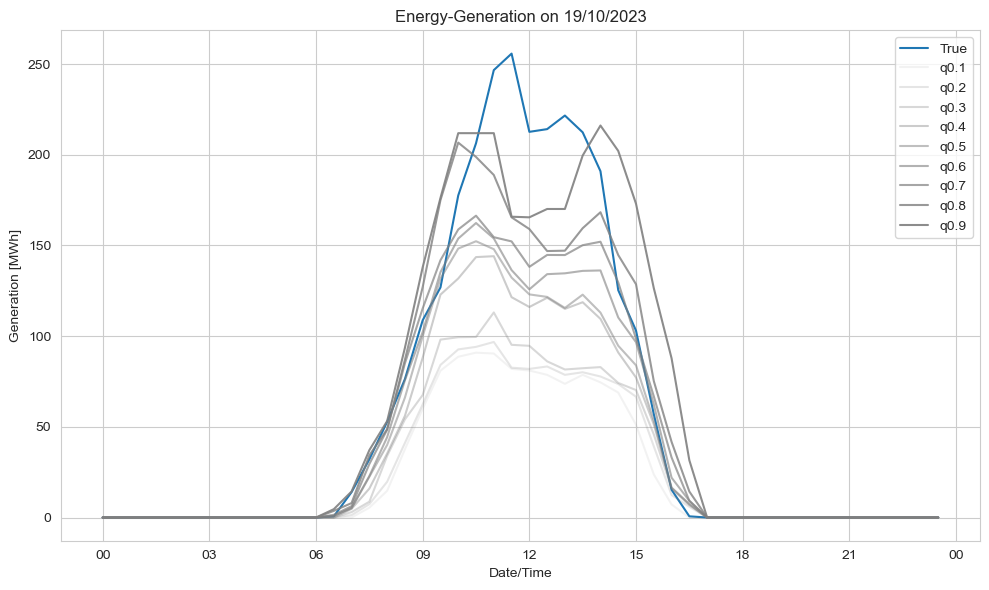

In [20]:
lgbm_model_solar_hyperparameter.plot_quantils(feature_engineerer_solar.y_test.index, lgbm_model_solar_hyperparameter.q_predictions, quantiles, year=2023, month=10, day=19)

In [21]:
performance_scores = {'Solarenergie' : [qr_model_solar.pinball_score(), lgbm_model_solar.pinball_score(), lgbm_model_solar_hyperparameter.pinball_score()],
                      'Windenergie' : [qr_model_wind.pinball_score(), lgbm_model_wind.pinball_score(), lgbm_model_wind_hyperparameter.pinball_score()]
                      }
performance_df = pd.DataFrame(performance_scores, index=["baseline", "LightGBM", "LightGBM_Hyperparametertuning"])
performance_df

,Solarenergie,Windenergie
baseline,11.914653,31.795997
LightGBM,8.938359,21.476032
LightGBM_Hyperparametertuning,9.082620,21.346469


### __conformalized quantile regression__

In [22]:
import Preprocessing
import importlib
importlib.reload(Preprocessing)

feature_engineerer_wind_cqr = Preprocessing.FeatureEngineerer(label = 'Wind_MWh_credit', columns_to_ohe = ['unavailabilityType', 'affectedUnit'])
feature_engineerer_wind_cqr.perform_feature_engineering(merged_hornsea, deployment = False, val_year=False)

importlib.reload(model_utils)
warnings.simplefilter("ignore", UserWarning)

quantiles = np.arange(0.1, 0.5, 0.1)
quantiles = np.round(quantiles, 1)

# Specify model save directory
model_save_dir_qr = "conformal_quantile_prediction_wind"

params_distributions = dict(
    num_leaves=randint(low=10, high=50),
    max_depth=randint(low=3, high=20),
    n_estimators=randint(low=50, high=100),
    learning_rate=uniform()
)

conformal_quantile_prediction_wind = model_utils.ConformalQuantilePredictionLGBM(feature_engineerer_wind_cqr, quantiles, model_save_dir=model_save_dir_qr, load_pretrained=False)
conformal_quantile_prediction_wind.train_and_predict(params_distributions)  # This will skip training for already loaded models
print(f"Quantile Regressor Pinball Score: {conformal_quantile_prediction_wind.pinball_score()}")

Saved Point Prediction model (50%-Quantile) to conformal_quantile_prediction_wind\point_prediction_lgbm.pkl
Saved Quantile Regressor model for quantile 0.1 and 0.9 to conformal_quantile_prediction_wind\conformal_quantile_prediction_lgbm0.1.pkl
Saved Quantile Regressor model for quantile 0.2 and 0.8 to conformal_quantile_prediction_wind\conformal_quantile_prediction_lgbm0.2.pkl
Saved Quantile Regressor model for quantile 0.3 and 0.7 to conformal_quantile_prediction_wind\conformal_quantile_prediction_lgbm0.3.pkl
Saved Quantile Regressor model for quantile 0.4 and 0.6 to conformal_quantile_prediction_wind\conformal_quantile_prediction_lgbm0.4.pkl
Quantile Regressor Pinball Score: 24.17327598965153


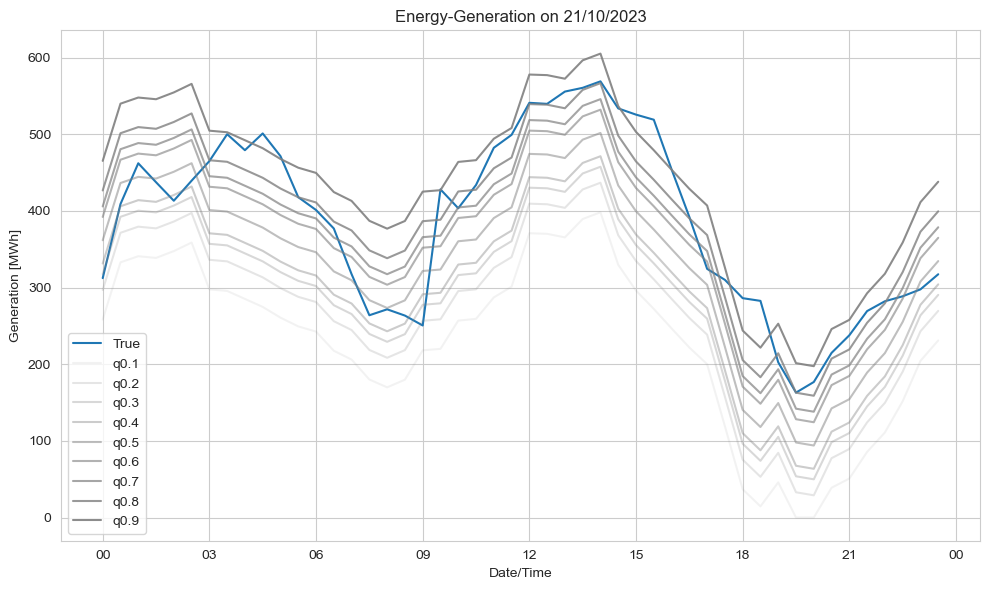

In [23]:
quantiles = np.arange(0.1, 1, 0.1)
quantiles = np.round(quantiles, 1)
conformal_quantile_prediction_wind.plot_quantils(feature_engineerer_wind_cqr.y_test.index, conformal_quantile_prediction_wind.q_predictions, quantiles, year=2023, month=10, day=21)

In [24]:
import Preprocessing
import importlib
importlib.reload(Preprocessing)

feature_engineerer_solar_cqr = Preprocessing.FeatureEngineerer(label = 'Solar_MWh_credit')
feature_engineerer_solar_cqr.perform_feature_engineering(merged_pes, deployment = False, val_year=False)

importlib.reload(model_utils)
warnings.simplefilter("ignore", UserWarning)

quantiles = np.arange(0.1, 0.5, 0.1)
quantiles = np.round(quantiles, 1)

# Specify model save directory
model_save_dir_qr = "conformal_quantile_prediction_solar"

params_distributions = dict(
    num_leaves=randint(low=10, high=50),
    max_depth=randint(low=3, high=20),
    n_estimators=randint(low=50, high=100),
    learning_rate=uniform()
)

conformal_quantile_prediction_solar = model_utils.ConformalQuantilePredictionLGBM(feature_engineerer_solar_cqr, quantiles, model_save_dir=model_save_dir_qr, load_pretrained=True)
conformal_quantile_prediction_solar.train_and_predict(params_distributions)  # This will skip training for already loaded models
print(f"Quantile Regressor Pinball Score: {conformal_quantile_prediction_solar.pinball_score()}")

Loaded pretrained Point Prediction model (50%-Quantile) from conformal_quantile_prediction_solar\point_prediction_lgbm.pkl
Loaded pretrained Quantile Regressor model for quantile 0.1 from conformal_quantile_prediction_solar\conformal_quantile_prediction_lgbm0.1.pkl
Loaded pretrained Quantile Regressor model for quantile 0.2 from conformal_quantile_prediction_solar\conformal_quantile_prediction_lgbm0.2.pkl
Loaded pretrained Quantile Regressor model for quantile 0.3 from conformal_quantile_prediction_solar\conformal_quantile_prediction_lgbm0.3.pkl
Loaded pretrained Quantile Regressor model for quantile 0.4 from conformal_quantile_prediction_solar\conformal_quantile_prediction_lgbm0.4.pkl
Using the loaded pretrained Point Prediction model (50%-Quantile).
Using the loaded pretrained Conformal Quantile Regressor model for quantile 0.1
Using the loaded pretrained Conformal Quantile Regressor model for quantile 0.2
Using the loaded pretrained Conformal Quantile Regressor model for quantile 0.

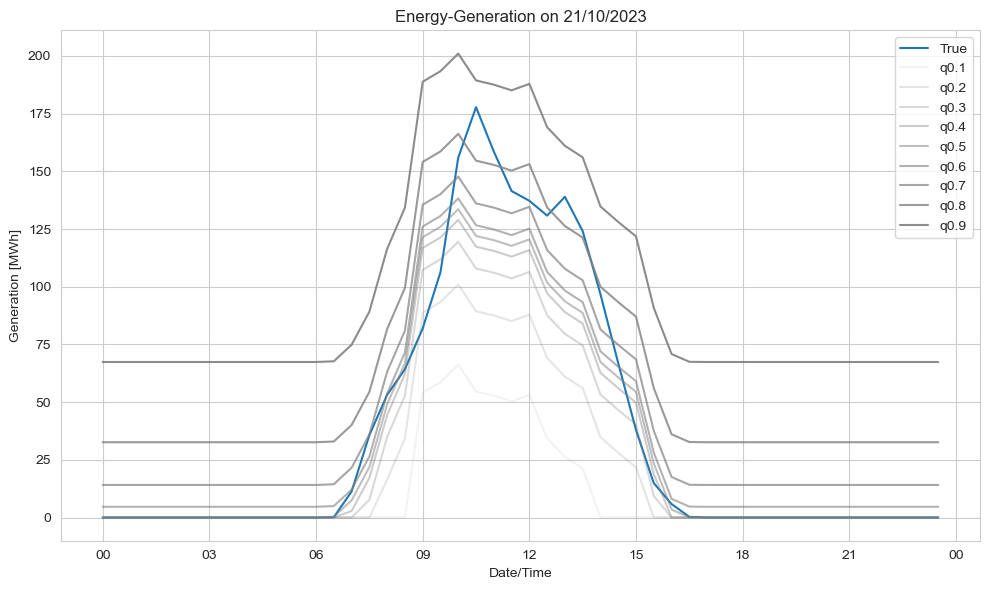

In [25]:
quantiles = np.arange(0.1, 1, 0.1)
quantiles = np.round(quantiles, 1)
conformal_quantile_prediction_solar.plot_quantils(feature_engineerer_solar_cqr.y_test.index, conformal_quantile_prediction_solar.q_predictions, quantiles, year=2023, month=10, day=21)

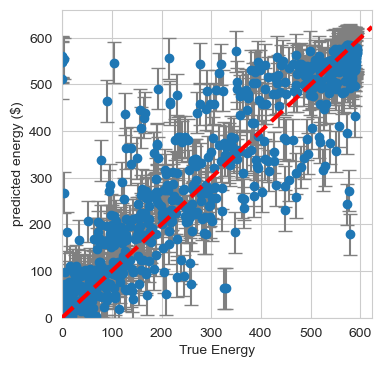

In [26]:
import matplotlib.pyplot as plt
predictions = pd.DataFrame(conformal_quantile_prediction_wind.q_predictions)
predictions = predictions.sample(frac=0.1, random_state=42)

fig, ax = plt.subplots(figsize=(4, 4))
alpha = 0.3
plt.errorbar(predictions["true"], predictions["0.5"], 
             yerr=(predictions["0.5"]-predictions[str(alpha)], predictions[str(np.round((1-alpha), 1))]-predictions["0.5"]),
             ecolor='grey', linestyle='', marker = "o", capsize=5)

ax.axline([0, 0], [1, 1], color = "red", linestyle='--', lw=3, zorder=3)
plt.xlim(0)
plt.ylim(0)
plt.xlabel('True Energy')
plt.ylabel('predicted energy ($)')
plt.show()

In [27]:
import pickle

# Pickle-Datei im Binär-Lesemodus ('rb') öffnen
with open('all_scores.pickle', 'rb') as f:
    # Laden des gesamten Dictionaries aus der Pickle-Datei
    model_predictions_dict = pickle.load(f)

# Jetzt kannst du auf die Modelle und ihre Predictions zugreifen
# Beispiel: Alle Modelle und ihre zugehörigen Predictions anzeigen

In [28]:
model_predictions_dict["CNN_LSTM"]["true"] = model_predictions_dict["True"]
model_predictions_dict["LSTM"]["true"] = model_predictions_dict["True"]
model_predictions_dict["LGBM"]["true"] = model_predictions_dict["True"]


In [29]:
df_cnn_lstm = pd.DataFrame(model_predictions_dict["CNN_LSTM"])
df_cnn_lstm.columns = df_cnn_lstm.columns.astype(str)
df_lstm = pd.DataFrame(model_predictions_dict["LSTM"])
df_lstm.columns = df_lstm.columns.astype(str)
df_lgbm = pd.DataFrame(model_predictions_dict["LGBM"])
df_lgbm.columns = df_lgbm.columns.astype(str)
df_cqr = pd.DataFrame(conformal_quantile_prediction_wind.q_predictions)

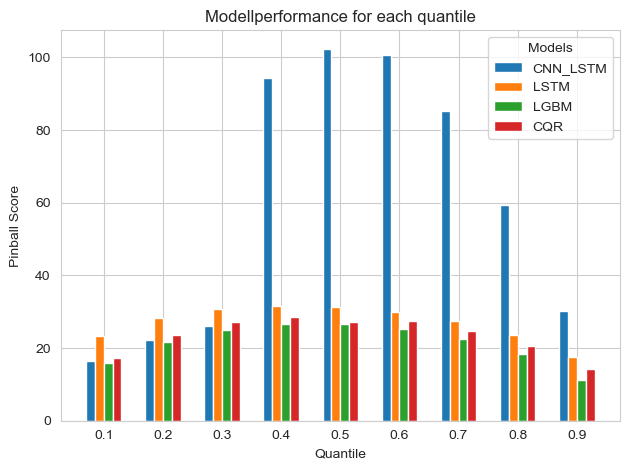

In [30]:
import model_utils
importlib.reload(model_utils)

quantiles = np.arange(0.1, 1.0, 0.1)
quantiles = np.round(quantiles, 1)

df_list = [df_cnn_lstm, df_lstm, df_lgbm, df_cqr]
names = ["CNN_LSTM", "LSTM", "LGBM", "CQR"]

model_utils.plot_quantile_performance(df_list, names, "Modellperformance for each quantile", quantiles, df_list=True)


### __Train Neural Networks__

__LSTM__

In [34]:
import ray

# Shut down Ray if it was running previously
ray.shutdown()

# Initialize Ray again
ray.init()

2024-10-21 20:05:23,475	INFO worker.py:1786 -- Started a local Ray instance.


Python version:,3.11.5
Ray version:,2.37.0


In [60]:
import ray.train
import torch
import numpy as np
import pandas as pd
from functools import partial
import ray
from ray import tune
from ray.tune.schedulers import ASHAScheduler
import neural_networks
from ray import train

def tune_trainable(config, feature_engineerer, model_class, quantiles):
    trainer = neural_networks.Trainer(
        feature_engineerer=feature_engineerer,
        model_class=model_class,
        quantiles=quantiles,
        optimizer_class=torch.optim.Adam,
        in_shape=config["in_shape"],
        dropout=config["dropout"],
        weight_decay=config["weight_decay"],
        lr=config["lr"],
        batch_size=config["batch_size"]
    )
    # trainer.fit(epochs=config['epochs'])

    trainer.train_and_test(epochs=config["epochs"])

    # After the training, get the pinball score
    pinball_score = model_utils.pinball_score(trainer.q_prediction_nn_df, quantiles=quantiles)
    
    # Report the pinball score to Ray Tune
    train.report({"pinball_score": pinball_score})  # Pass pinball_score as a dictionary

# Run Ray Tune
def custom_trial_dirname_creator(trial):
    # Only use the trial_id, which is short, to create the directory
    return f"trial_{trial.trial_id}"

# Update the tune.run command with the custom trial directory name creator
def run_ray_tune(feature_engineerer, model_class, quantiles):
    config = {
        "in_shape": tune.choice([25, 50, 75]),
        "dropout": tune.uniform(0.25, 0.5),
        "weight_decay": tune.loguniform(1e-6, 1e-3),
        "lr": tune.loguniform(1e-4, 1e-2),
        "batch_size": tune.choice([32, 48, 64]),
        "epochs": tune.choice([50, 75, 100, ])
    }

    # Define an early stopping scheduler
    scheduler = ASHAScheduler(
        max_t=150,
        grace_period=10,
        reduction_factor=2
    )

    # Run the hyperparameter search
    analysis = tune.run(
        partial(tune_trainable, feature_engineerer=feature_engineerer, model_class=model_class, quantiles=quantiles),
        config=config,
        num_samples=15,
        scheduler=scheduler,
        trial_dirname_creator=custom_trial_dirname_creator,  # Use the custom directory name creator
        metric="pinball_score",  # Specify the metric to optimize
        mode="min",  # Specify that we want to minimize the pinball_score
    )

    print("Best hyperparameters found were: ", analysis.best_config)
    return analysis.best_config

# Example of calling Ray Tune
# Assuming `feature_engineerer`, `LSTM_model`, and `quantiles` are defined
best_hyperparamter = run_ray_tune(feature_engineerer_wind, neural_networks.LSTM_model, quantiles=np.arange(0.1, 1.0, 0.1).round(2))


2024-10-21 23:51:28,645	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


(raylet) Warning: The actor ImplicitFunc is very large (67 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.


2024-10-21 23:51:52,332	WARNING tune.py:219 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2024-10-21 23:51:52,350	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'C:/Users/maxda/ray_results/tune_trainable_2024-10-21_23-51-28' in 0.0136s.
2024-10-21 23:52:02,845	INFO tune.py:1041 -- Total run time: 34.20 seconds (23.39 seconds for the tuning loop).
2024-10-21 23:52:02,851	WARNING tune.py:1056 -- Experiment has been interrupted, but the most recent state was saved.
Resume experiment with: tune.run(..., resume=True)
2024-10-21 23:52:02,946	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 15 trial(s):
- tune_trainable_a0820_00000: FileNotFoundError('Could not fetch metrics for tune_trainable_a0820_00000: both result.json and progress.csv were not found at C:/Users/maxda/ray_results/tune_tr

Best hyperparameters found were:  None


In [52]:
importlib.reload(model_utils)
import neural_networks
importlib.reload(neural_networks)

quantiles = np.arange(0.1, 1.0, 0.1)
quantiles = np.round(quantiles, 1)

# Specify model save directory
model_save_dir = "lstm_model_wind.pth"

lstm_wind = neural_networks.Trainer(feature_engineerer_wind,  
                                    neural_networks.LSTM_model,
                                    quantiles, 
                                    optimizer_class=torch.optim.Adam,
                                    lr = best_hyperparamter["lr"], 
                                    batch_size = best_hyperparamter["batch_size"],
                                    in_shape=best_hyperparamter["in_shape"], 
                                    dropout=best_hyperparamter["dropout"],
                                    weight_decay=best_hyperparamter["weight_decay"],
                                    model_path=model_save_dir, 
                                    load_pretrained=False)
lstm_wind.train_and_test(epochs=best_hyperparamter["epochs"])

0. epoche startet: 
1. epoche startet: 
2. epoche startet: 
3. epoche startet: 
4. epoche startet: 
5. epoche startet: 
6. epoche startet: 
7. epoche startet: 
8. epoche startet: 
9. epoche startet: 
Epoch 10: 956.7620239257812
10. epoche startet: 
11. epoche startet: 
12. epoche startet: 
13. epoche startet: 
14. epoche startet: 
15. epoche startet: 
16. epoche startet: 
17. epoche startet: 
18. epoche startet: 
19. epoche startet: 
Epoch 20: 699.6874389648438
20. epoche startet: 
21. epoche startet: 
22. epoche startet: 
23. epoche startet: 
24. epoche startet: 
25. epoche startet: 
26. epoche startet: 
27. epoche startet: 
28. epoche startet: 
29. epoche startet: 
Epoch 30: 509.1783142089844
30. epoche startet: 
31. epoche startet: 
32. epoche startet: 
33. epoche startet: 
34. epoche startet: 
35. epoche startet: 
36. epoche startet: 
37. epoche startet: 
38. epoche startet: 
39. epoche startet: 
Epoch 40: 358.9994201660156
40. epoche startet: 
41. epoche startet: 
42. epoche start

### __Mean Ensemble Modell__

### __Stacking Ensemble Modell__

In [90]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression, Ridge
q_prediction_ensemble = {}
q_prediction_ensemble["true"] = feature_engineerer_wind.y_test.values

for qu in quantiles:

    level0 = list()
    level0.append(("baseline", qr_model_wind.models[qu]))
    level0.append(("lgbm", lgbm_model_wind.models[qu]))
    # level0.append(("lstm", lstm_wind))
    level1 = Ridge()

    model = StackingRegressor(estimators=level0, final_estimator=level1)

    model.fit(feature_engineerer_wind.X_val, feature_engineerer_wind.y_val)

    q_prediction_ensemble[str(qu)] = model.predict(feature_engineerer_wind.X_test)

    

In [93]:
df_ensemble = pd.DataFrame(q_prediction_ensemble)

In [94]:
model_utils.pinball_score(df_ensemble, quantiles)

31.622384229706014

CNN LSTM

In [1]:
from neural_networks import *
import importlib
import Preprocessing
importlib.reload(Preprocessing)

import model_utils
import pandas as pd

merged_hornsea = pd.read_parquet("preprocessed_hornsea_with_energy.parquet")
merged_pes = pd.read_parquet("preprocessed_pes_with_energy.parquet")

feature_engineerer_wind = Preprocessing.FeatureEngineerer(label = 'Wind_MWh_credit', columns_to_ohe = ['unavailabilityType', 'affectedUnit'])
feature_engineerer_wind.perform_feature_engineering(merged_hornsea, deployment = False)

feature_engineerer_solar = Preprocessing.FeatureEngineerer(label = "Solar_MWh_credit")
feature_engineerer_solar.perform_feature_engineering(merged_pes, deployment = False)

# source: https://github.com/TheQuantScientist/CNN-LSTM-AM/blob/main/src/CLAM.ipynb
cnn_lstm = CNN_LSTM(feature_engineerer = feature_engineerer_wind, forecast_length = 1, sequence_length = 1, cnn_filters = 100, lstm_layers = 50)
cnn_lstm.model_save_dir = "CNN_LSTM"
cnn_lstm.model_name = "CNN_LSTM_wind"
pred_and_true = cnn_lstm.predict_with_keras(use_test_data = True)
#cnn_lstm.fit_models(model_name = "CNN_LSTM_wind_1CNN1LSTM", model_save_dir = "CNN_LSTM", verbose = 1, batch_size = 16, epochs = 40, lr = 0.01)


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\pytorch_forecasting\models\base_model.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


276/276 [==============================] - 1s 784us/step


In [2]:
pred_and_true = cnn_lstm.predict_with_keras(use_test_data = True)
cnn_lstm.sort_quantiles(pred_and_true, quantiles = pred_and_true.columns)

276/276 [==============================] - 1s 649us/step


,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
dtm,,,,,,,,,
2023-07-01 00:00:00+00:00,467.795624,468.915863,505.988464,509.160217,524.324158,524.672302,543.285278,592.355530,612.253906
2023-07-01 00:30:00+00:00,463.696747,465.347382,504.554565,505.451111,514.419922,517.860962,540.772278,589.010315,612.035767
2023-07-01 01:00:00+00:00,460.300964,464.339417,500.571777,504.981079,511.066223,511.449249,538.216370,584.702209,611.721863
2023-07-01 01:30:00+00:00,460.713684,465.755249,499.941650,504.864685,511.053711,511.316010,538.511902,583.259094,611.636536
2023-07-01 02:00:00+00:00,461.077576,466.549133,497.852844,504.364532,510.766357,511.040771,537.460632,581.958313,611.449890
...,...,...,...,...,...,...,...,...,...
2023-12-31 21:30:00+00:00,482.348877,508.162079,524.931396,538.759460,553.213196,565.106201,579.689697,600.105774,613.175415
2023-12-31 22:00:00+00:00,482.349854,508.165802,524.932190,538.750671,553.212708,565.083008,579.692505,600.102905,613.175354
2023-12-31 22:30:00+00:00,482.348572,507.564453,524.932617,538.723083,553.175476,565.042542,579.611450,600.121094,613.175171


In [ ]:
# cnn_lstm_solar = CNN_LSTM(feature_engineerer = feature_engineerer_solar, forecast_length = 1, sequence_length = 1, cnn_filters = 64, lstm_layers = 30)
# cnn_lstm_solar.fit_models(model_name = "CNN_LSTM_solar", model_save_dir = "CNN_LSTM", verbose = 1, batch_size = 64, epochs = 40, lr = 0.01)

In [ ]:
def pinball_score_nn_single(df, qu):
    score = model_utils.pinball(y=df["true"],
                             q=df[f"{qu}"],
                             alpha=qu).mean()
    return score

scores = list()
for q in np.arange(0.1, 1.0, 0.1).round(2):
    print(f"{q}", pinball_score_nn_single(pred_and_true, q))
    scores.append(pinball_score_nn_single(pred_and_true, q))

In [ ]:
np.array(scores).mean()

In [ ]:
import plotly.express as px

px.line(pred_and_true, y = ["true", "0.5", "0.1", "0.9"])